In [1]:
!pip install alibi

In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TF version:  2.3.0
Eager execution enabled:  False


Loading the iris dataset

In [27]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)
class_names,feature_names

(['setosa', 'versicolor', 'virginica'],
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

Sacling the data, and splitting the data into training and testing

In [31]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)
idx = 145
x_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
x_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Defining the Logistic Regression model

In [6]:
def lr_model():
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

Training the LR model

In [7]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


## Generating Contasting explanation with PN (pertinent negative)

Taking an instance from the training set

In [8]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(lr.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(lr.predict(X)))

Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[2.6480018e-04 2.3783095e-01 7.6190418e-01]]


We can see that the model predicted the virginica class with 76% probability.

Defining the CEM parameters

In [32]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 x_train.max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

Generating PN

In [10]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')  # we need to define what feature values contain the least
                                         # info wrt predictions
                                         # here we will naively assume that the feature-wise median
                                         # contains no info; domain knowledge helps!
explanation = cem.explain(X, verbose=False)

In [11]:
print('Original instance: {}'.format(explanation.X))
print('Predicted class: {}'.format(class_names[explanation.X_pred]))
print('Pertinent negative: {}'.format(explanation.PN))
print('Predicted class: {}'.format(class_names[explanation.PN_pred]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica
Pertinent negative: [[ 0.5533333  -1.2829633  -0.82326424  0.92230284]]
Predicted class: versicolor


Storing the explanation

In [12]:
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

Generating PP (pertinent positive)

In [13]:
mode = 'PP'

In [14]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [15]:
print('Pertinent positive: {}'.format(explanation.PP))
print('Predicted class: {}'.format(class_names[explanation.PP_pred]))

Pertinent positive: [[-7.44469730e-09 -3.47054341e-08  2.40787056e-01  9.05528027e-01]]
Predicted class: virginica


In [16]:
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

## Visualizing PN & PP

In [17]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

Adding pertinent negative and positive to the dataset:

In [18]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)


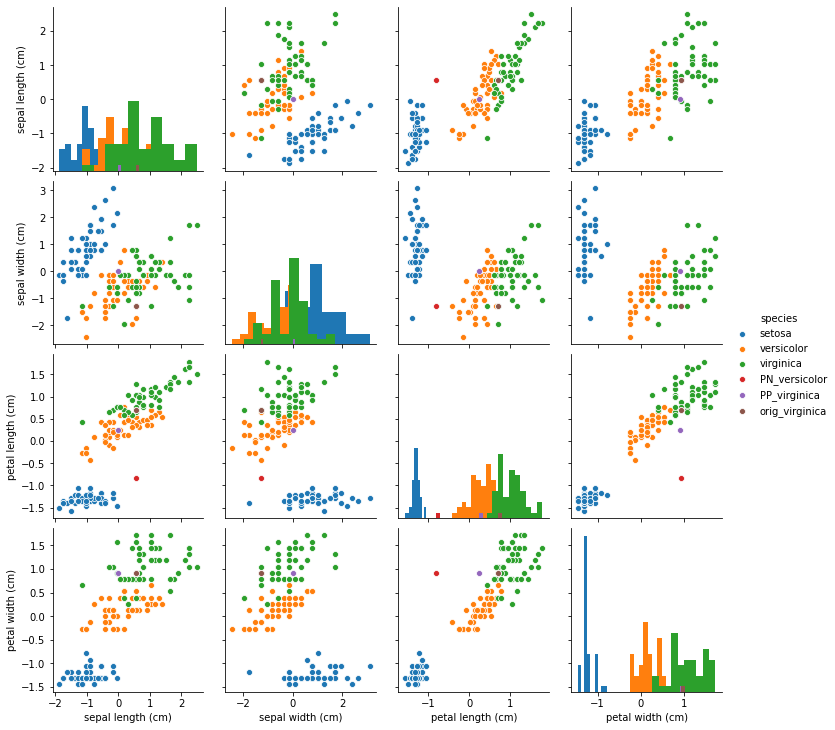

In [19]:
fig = sns.pairplot(df, hue='species', diag_kind='hist');

Pair plots between the features show that the pertinent negative is pushed from the original instance (versicolor) into the virginica distribution while the pertinent positive moved away from the virginica distribution.

In [20]:
mode = 'PN'

In [21]:
eps0 = np.array([[1e-2, 1e-2, 1e-2]])  # 3 prediction categories, equivalent to 1e-2
eps1 = np.array([[1e-2, 1e-2, 1e-2, 1e-2]])  # 4 features, also equivalent to 1e-2
eps = (eps0, eps1)

In [22]:
update_num_grad = 1

In [23]:
# define model
lr = load_model('iris_lr.h5')
predict_fn = lambda x: lr.predict(x)  # only pass the predict fn which takes numpy arrays to CEM
                                      # explainer can no longer minimize wrt model weights

# initialize CEM explainer and explain instance
cem = CEM(predict_fn, mode, shape, kappa=kappa, beta=beta,
          feature_range=feature_range, max_iterations=max_iterations,
          eps=eps, c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init,
          clip=clip, update_num_grad=update_num_grad)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [24]:
print('Original instance: {}'.format(explanation.X))
print('Predicted class: {}'.format(class_names[explanation.X_pred]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica
